In [8]:
from cfl.experiment import Experiment
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from cfl_helpers import *

In [9]:
resolution = '100km'
train_file = f'data/{resolution}_data.csv'
test_file = f'data/13km_truth.csv'

train_data = pd.read_csv(train_file)
trainX, trainY = np.array(train_data[['lat', 'long']]), np.array(train_data['generated_temp']).reshape(-1,1)
trainX = StandardScaler().fit_transform(trainX)
trainY = StandardScaler().fit_transform(trainY)

test_data = pd.read_csv(test_file)
del test_data['elevation']
testX, testY = np.array(test_data[['lat', 'long']]), np.array(test_data['generated_temp']).reshape(-1,1)
testX = StandardScaler().fit_transform(testX)
testY = StandardScaler().fit_transform(testY)

print('Training data shape:', trainX.shape, trainY.shape)
print('Test data shape:', testX.shape, testY.shape)

Training data shape: (131, 2) (131, 1)
Test data shape: (7487, 2) (7487, 1)


In [10]:
data_info = {'X_dims' : trainX.shape,
             'Y_dims' : trainY.shape,
             'Y_type' : 'continuous' #options: 'categorical' or 'continuous'
            }

CDE_params = {  'model'        : 'CondExpMod',
                'model_params' : {
                    # model architecture
                    'dense_units' : [50, data_info['Y_dims'][1]],
                    'activations' : ['relu', 'linear'],
                    'dropouts'    : [0, 0],
                    # training parameters
                    'batch_size'  : 64,
                    'n_epochs'    : 2000,
                    'optimizer'   : 'adam',
                    'opt_config'  : {'lr' : 1e-4},
                    'loss'        : 'mean_squared_error',
                    'best'        : True,
                    'early_stopping' : True,
                    # verbosity
                    'verbose'     : 0, # don't log or show plot for checking clusters vs accuracy
                    'show_plot'   : False,
                }
}

# CAUSE CLUSTER PARAMS VARIED

In [11]:
'''
# old tests for checking clusters

cause_cluster_params =  {'model' : 'KMeans',
                        'model_params' : {'n_clusters' : 10},
                        'verbose' : 0
}

block_names = ['CondDensityEstimator', 'CauseClusterer']
block_params = [CDE_params, cause_cluster_params]
results_path = 'sample' # directory to save results to

my_exp = Experiment(X_train=trainX,
                    Y_train=trainY,
                    data_info=data_info,
                    block_names=block_names,
                    block_params=block_params,
                    results_path=results_path)
results = my_exp.train()
xlbls = results['CauseClusterer']['x_lbls']

my_exp.add_dataset(X=testX, Y=testY, dataset_name='test_data')
pred_results = my_exp.predict('test_data')
pred_xlbls = pred_results['CauseClusterer']['x_lbls']

# print(xlbls) # on 40km dataset
train_lbl_avg, train_lbl_dict = get_group_avgs(train_data, xlbls)
print(train_lbl_avg)
train_counts = {i: len(train_lbl_dict[i]) for i in range(10)}
counts_sum = sum(train_counts.values())
train_counts_prop = {k: round(v / counts_sum, 2) for k, v in train_counts.items()}
print(train_counts_prop)

test_lbl_avg, test_lbl_dict = get_group_avgs(test_data, pred_xlbls)
preds = list(pred_xlbls)

print()
print(test_lbl_avg)
test_counts = {i: len(test_lbl_dict[i]) for i in range(10)}
counts_sum = sum(test_counts.values())
test_counts_prop = {k: round(v / counts_sum, 2) for k, v in test_counts.items()}
print(test_counts_prop)
'''

"\n# old tests for checking clusters\n\ncause_cluster_params =  {'model' : 'KMeans',\n                        'model_params' : {'n_clusters' : 10},\n                        'verbose' : 0\n}\n\nblock_names = ['CondDensityEstimator', 'CauseClusterer']\nblock_params = [CDE_params, cause_cluster_params]\nresults_path = 'sample' # directory to save results to\n\nmy_exp = Experiment(X_train=trainX,\n                    Y_train=trainY,\n                    data_info=data_info,\n                    block_names=block_names,\n                    block_params=block_params,\n                    results_path=results_path)\nresults = my_exp.train()\nxlbls = results['CauseClusterer']['x_lbls']\n\nmy_exp.add_dataset(X=testX, Y=testY, dataset_name='test_data')\npred_results = my_exp.predict('test_data')\npred_xlbls = pred_results['CauseClusterer']['x_lbls']\n\n# print(xlbls) # on 40km dataset\ntrain_lbl_avg, train_lbl_dict = get_group_avgs(train_data, xlbls)\nprint(train_lbl_avg)\ntrain_counts = {i: le

In [12]:
# n_clusters = [1, 5, 10, 30, 50, 75, 100, 150, 200] # for 10km
# n_clusters = [1, 3, 5, 7, 10, 15, 20, 30, 50, 100, 200] # for 25km
n_clusters = [1, 2, 3, 5, 7, 10, 15, 20, 30, 40, 50] # for 40km

sq_errs = []

for n in n_clusters:
    cause_cluster_params =  {'model' : 'KMeans',
                         'model_params' : {'n_clusters' : n},
                         'verbose' : 0
    }

    block_names = ['CondDensityEstimator', 'CauseClusterer']
    block_params = [CDE_params, cause_cluster_params]
    results_path = 'sample_run_2' # directory to save results to

    my_exp = Experiment(X_train=trainX,
                        Y_train=trainY,
                        data_info=data_info,
                        block_names=block_names,
                        block_params=block_params,
                        results_path=results_path)
    results = my_exp.train()
    xlbls = results['CauseClusterer']['x_lbls']

    my_exp.add_dataset(X=testX, Y=testY, dataset_name='test_data')
    pred_results = my_exp.predict('test_data')
    pred_xlbls = pred_results['CauseClusterer']['x_lbls']

    sq_errs.append(by_cluster_err(train_data, xlbls, test_data, pred_xlbls))
    print(f'sq_err for {n} clusters: {sq_errs[-1]}')


All results from this run will be saved to sample_run_2/experiment0139
Block: verbose not specified in input, defaulting to 1
#################### Beginning CFL Experiment training. ####################
Beginning CondDensityEstimator training...
5/5 [==============================] - 0s 1ms/step
CondDensityEstimator training complete.
Beginning CauseClusterer training...
CauseClusterer training complete.
Experiment training complete.
Beginning Experiment prediction.
Beginning CondDensityEstimator prediction...
234/234 [==============================] - 0s 1ms/step
CondDensityEstimator prediction complete.
Beginning CauseClusterer prediction...
CauseClusterer prediction complete.
Prediction complete.
sq_err for 1 clusters: 3.159145348390835
All results from this run will be saved to sample_run_2/experiment0140
#################### Beginning CFL Experiment training. ####################
Beginning CondDensityEstimator training...
5/5 [==============================] - 0s 1ms/step
CondDens

[3.159145348390835, 3.4028840254906356, 2.929522843609823, 2.731297548224328, 2.9109149730599504, 3.383145587835144, 3.492858057265921, 2.640492710082161, 3.371741308065079, 4.262599416249037, 3.7930348559764453]


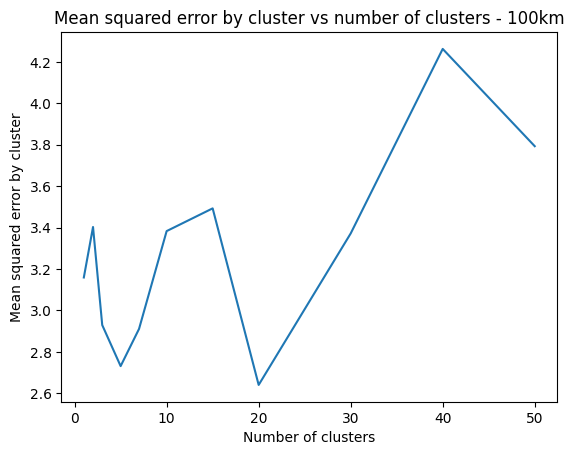

In [13]:
import matplotlib.pyplot as plt

print(sq_errs)

plt.figure(0)
plt.plot(n_clusters, sq_errs)
plt.xlabel('Number of clusters')
plt.ylabel('Mean squared error by cluster')
_ = plt.title(f'Mean squared error by cluster vs number of clusters - {resolution}')

In [14]:
print(xlbls)
print(pred_xlbls)

[45 20 19 44  0 26 28 13 21 46  7  5  2  6 39  1 38 11 48 27 28 25 33 16
 41 19  2 19  4 17 45 36 26 12 26 15 37 44 47  5  5 42 22 15 14 31  7 11
 11 22 16  7 43 14 17 38 30  0 16  7 38 34 25  1  3  7 16  7 24  3 32  9
 35 44 49  7 49  3 31  9  1 33 38 24 38 44 31 17  1 10  8 45  8 40 10 17
 23 10  8  7 29  8 10 35 23 25  8 29  0 29 38 10  1  9 32 29 22 36 16 49
 33  1 25 34 22 42 20 30 18 40 17]
[11 20 42 ... 23 23 37]
